In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

%pip install torch torchvision torchaudio

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

Note: you may need to restart the kernel to use updated packages.


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
ticker = 'AAPL'
df = yf.download(ticker, start = '2020-01-01', auto_adjust = True)
df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.468269,72.528589,71.223267,71.476607,135480400
2020-01-03,71.763718,72.523746,71.539330,71.696160,146322800
2020-01-06,72.335556,72.374162,70.634539,70.885472,118387200
2020-01-07,71.995354,72.600960,71.775789,72.345204,108872000
2020-01-08,73.153488,73.455087,71.698574,71.698574,132079200
...,...,...,...,...,...
2025-12-09,277.179993,280.029999,276.920013,278.160004,32193300
2025-12-10,278.779999,279.750000,276.440002,277.750000,33038300


<Axes: xlabel='Date'>

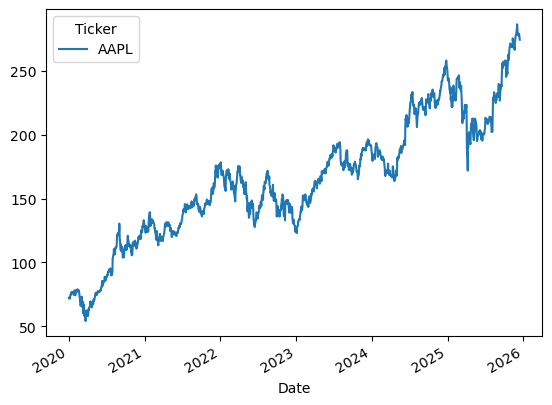

In [4]:
df.Close.plot()

In [5]:
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df['Close'])
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.870548
2020-01-03,-1.884923
2020-01-06,-1.873256
2020-01-07,-1.880197
2020-01-08,-1.856568
...,...
2025-12-09,2.306173
2025-12-10,2.338818
2025-12-11,2.323516


In [6]:
seq_length = 30
data = []
for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

In [7]:
data

array([[[-1.87054808],
        [-1.884923  ],
        [-1.87325582],
        ...,
        [-1.77200106],
        [-1.73454799],
        [-1.7460455 ]],

       [[-1.884923  ],
        [-1.87325582],
        [-1.88019695],
        ...,
        [-1.73454799],
        [-1.7460455 ],
        [-1.74565074]],

       [[-1.87325582],
        [-1.88019695],
        [-1.8565676 ],
        ...,
        [-1.7460455 ],
        [-1.74565074],
        [-1.77501079]],

       ...,

       [[ 2.14823007],
        [ 2.18288107],
        [ 2.16188662],
        ...,
        [ 2.32065945],
        [ 2.30617291],
        [ 2.33881774]],

       [[ 2.18288107],
        [ 2.16188662],
        [ 2.13498074],
        ...,
        [ 2.30617291],
        [ 2.33881774],
        [ 2.32351554]],

       [[ 2.16188662],
        [ 2.13498074],
        [ 2.15516015],
        ...,
        [ 2.33881774],
        [ 2.32351554],
        [ 2.32861627]]])

In [8]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[:train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[:train_size:, -1, :]).type(torch.Tensor).to(device)

In [9]:
class PredictionModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim ,device = device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim ,device = device)

        out, (hn,cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        
        return out

In [10]:
model = PredictionModel(input_dim = 1, hidden_dim = 32, num_layers = 2, output_dim = 1).to(device)

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [12]:
num_epochs = 200

for i in range(num_epochs): 
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i, loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

0 0.7136990427970886
25 0.5862176418304443
50 0.46567150950431824
75 0.4045531153678894
100 0.304934024810791
125 0.16841469705104828
150 0.0959576815366745
175 0.08396149426698685


In [13]:
model.eval()


y_test_pred = model(X_test)



y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [14]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

In [15]:
train_rmse


16.317514419555664

In [16]:
test_rmse

16.317514419555664

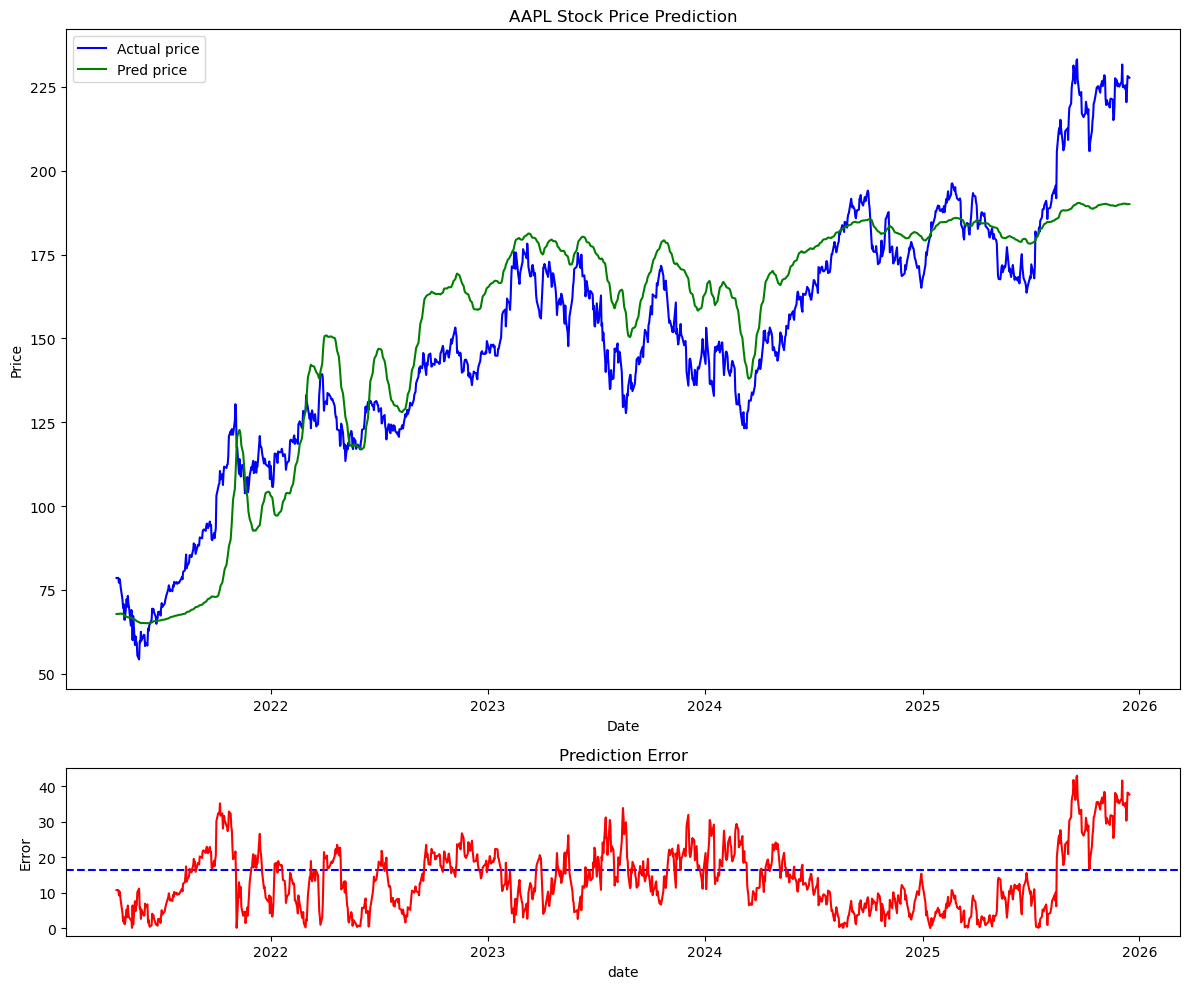

In [19]:
fig = plt.figure(figsize = (12,10))

gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'Green', label = 'Pred price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3,0])
ax2.axhline(test_rmse, color = 'blue' , linestyle = '--' , label = 'RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label = 'Prediciton error')
plt.title('Prediction Error')
plt.xlabel('date')
plt.ylabel('Error')
plt.tight_layout()
plt.show()

